<a href="https://colab.research.google.com/github/KauanIzaias22/Plano-IA/blob/main/Plano_de_trabalho_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy scikit-learn networkx matplotlib






In [13]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


In [14]:
# Exemplo de pedidos falsos (lat/lon simulados)
np.random.seed(42)
orders = pd.DataFrame({
    "id": range(1, 21),
    "lat": np.random.uniform(-23.6, -23.5, 20),
    "lon": np.random.uniform(-46.7, -46.6, 20)
})
orders.head()


,id,lat,lon
0,1,-23.562546,-46.638815
1,2,-23.504929,-46.686051
2,3,-23.526801,-46.670786
3,4,-23.540134,-46.663364
4,5,-23.584398,-46.654393


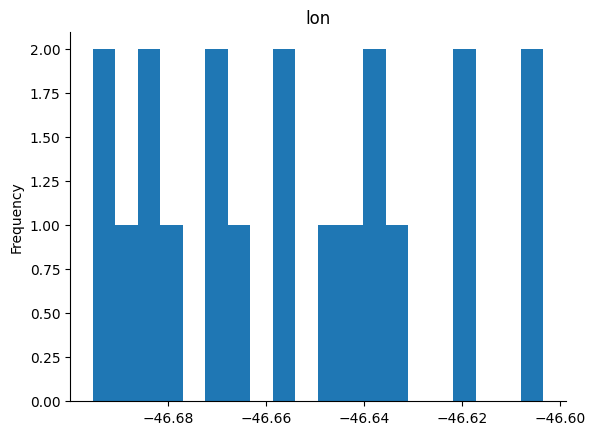

In [15]:
# @title Grafico

from matplotlib import pyplot as plt
orders['lon'].plot(kind='hist', bins=20, title='lon')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Aplicação do KMeans

Aqui utilizamos o algoritmo **KMeans** para realizar a **segmentação de pedidos** com base nas coordenadas de latitude e longitude.  
O objetivo é agrupar os pontos de forma que pedidos próximos geograficamente pertençam ao mesmo cluster, auxiliando na **logística e planejamento de rotas**.


   id        lat        lon  cluster
0   1 -23.587796 -46.622776        1
1   2 -23.550482 -46.680128        2
2   3 -23.596561 -46.699448        3
3   4 -23.509068 -46.618454        0
4   5 -23.574122 -46.629314        1


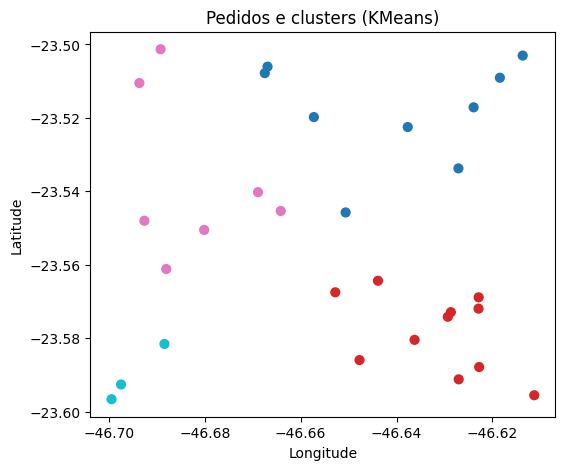

In [16]:
# --- GERA PEDIDOS SIMULADOS (ou carregue seu orders.csv)
n_orders = 30
orders = pd.DataFrame({
    "id": range(1, n_orders+1),
    "lat": np.random.uniform(-23.60, -23.50, n_orders),
    "lon": np.random.uniform(-46.70, -46.60, n_orders)
})

# K-Means: ajuste n_clusters conforme número de entregadores
n_clusters = 4
coords = orders[['lat','lon']].values
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(coords)
orders['cluster'] = kmeans.labels_

# Mostrar head e scatter
print(orders.head())
plt.figure(figsize=(6,5))
plt.scatter(orders['lon'], orders['lat'], c=orders['cluster'], cmap='tab10', s=40)
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title("Pedidos e clusters (KMeans)")
plt.show()



## Representação em Grafo dos Pedidos

Nesta etapa, os pedidos foram mapeados em uma **estrutura de grafo em grade**, onde cada nó representa uma coordenada de latitude/longitude.  
O objetivo é visualizar como os pedidos pod


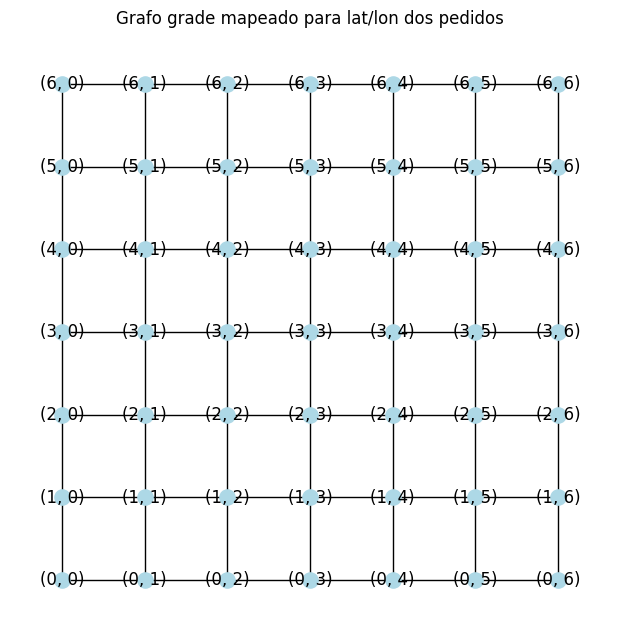

In [17]:
import math
def build_grid_graph(rows, cols, min_lat, max_lat, min_lon, max_lon):
    G = nx.Graph()
    lat_grid = np.linspace(min_lat, max_lat, rows)
    lon_grid = np.linspace(min_lon, max_lon, cols)
    pos = {}  # mapa nó -> (lon, lat) para plot
    for i in range(rows):
        for j in range(cols):
            node = (i, j)
            # note: pos as (x, y) = (lon, lat) para plot coerente
            pos[node] = (lon_grid[j], lat_grid[i])
            G.add_node(node)
    # conectar vizinhos (4-neighborhood) com peso = euclidiana em coordenadas lon/lat
    for i in range(rows):
        for j in range(cols):
            node = (i,j)
            neighbors = [ (i+1,j), (i-1,j), (i,j+1), (i,j-1) ]
            for nb in neighbors:
                if 0 <= nb[0] < rows and 0 <= nb[1] < cols:
                    if not G.has_edge(node, nb):
                        x1,y1 = pos[node]; x2,y2 = pos[nb]
                        w = math.hypot(x1-x2, y1-y2)
                        G.add_edge(node, nb, weight=w)
    return G, pos

# criar grafo 7x7 (aumente se quiser)
rows, cols = 7, 7
min_lat, max_lat = orders['lat'].min(), orders['lat'].max()
min_lon, max_lon = orders['lon'].min(), orders['lon'].max()
G, pos = build_grid_graph(rows, cols, min_lat, max_lat, min_lon, max_lon)

# plot do grafo (nós com coordenadas de lat/lon)
plt.figure(figsize=(6,6))
nx.draw(G, pos=pos, node_color='lightblue', with_labels=True, node_size=120)
plt.title("Grafo grade mapeado para lat/lon dos pedidos")
plt.show()

## Visualização dos Clusters

O gráfico abaixo mostra os **clusters formados pelo KMeans**, onde cada cor representa um grupo distinto de pedidos.  
É possível observar como os pontos foram agrupados de acordo com a proximidade geográfica, revelando áreas de maior concentração.


   id        lat        lon  cluster    node
0   1 -23.587796 -46.622776        1  (1, 5)
1   2 -23.550482 -46.680128        2  (3, 1)
2   3 -23.596561 -46.699448        3  (0, 0)
3   4 -23.509068 -46.618454        0  (6, 6)
4   5 -23.574122 -46.629314        1  (1, 5)


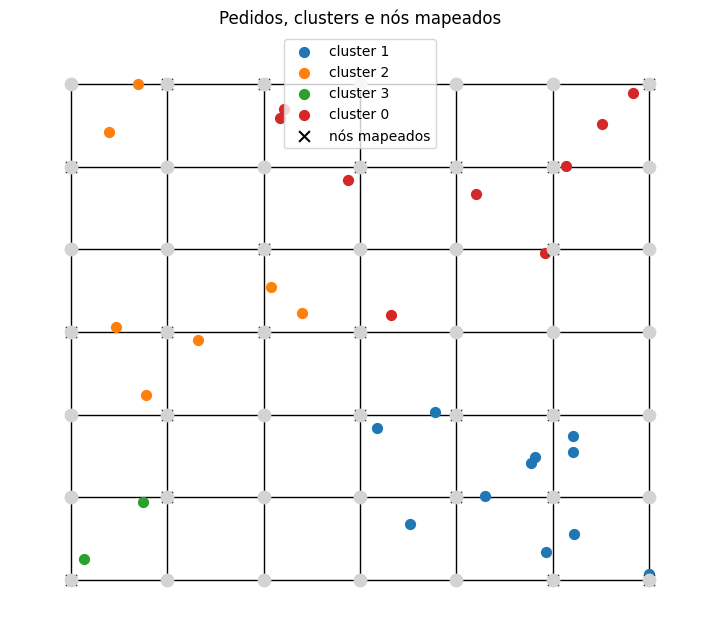

In [18]:
def nearest_node_for_point(lat, lon, pos):
    # pos: dict node -> (lon, lat)
    best = None
    best_d = float('inf')
    for node, (node_lon, node_lat) in pos.items():
        d = math.hypot(lon - node_lon, lat - node_lat)
        if d < best_d:
            best_d = d
            best = node
    return best

orders['node'] = orders.apply(lambda r: nearest_node_for_point(r['lat'], r['lon'], pos), axis=1)
print(orders[['id','lat','lon','cluster','node']].head())

# plot: pedidos (pontos) + nós mapeados
plt.figure(figsize=(7,6))
# plot nodes
nx.draw(G, pos=pos, node_color='lightgrey', node_size=80, with_labels=False)
# plot orders
for c in orders['cluster'].unique():
    group = orders[orders['cluster']==c]
    plt.scatter(group['lon'], group['lat'], label=f'cluster {c}', s=50)
# opcional: plot das posições dos nós correspondentes
mapped_nodes = orders['node'].unique()
node_coords = [pos[n] for n in mapped_nodes]
nx_nodes_x = [p[0] for p in node_coords]; nx_nodes_y = [p[1] for p in node_coords]
plt.scatter(nx_nodes_x, nx_nodes_y, c='k', marker='x', s=60, label='nós mapeados')
plt.legend()
plt.title("Pedidos, clusters e nós mapeados")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.show()


In [19]:
# calcula distância mínima (peso do grafo) entre um nó e todos os outros (Dijkstra)
def all_pairs_shortest_paths_lengths(G, nodes):
    # retorna dict[src][tgt] = distância e paths dict[src][tgt]=path
    lengths = {}
    paths = {}
    for src in nodes:
        l, p = nx.single_source_dijkstra(G, source=src, weight='weight')
        # filtrar p para apenas nodes de interesse: mas podemos guardar todos e indexar
        lengths[src] = {t: l[t] for t in nodes}
        paths[src] = {t: p[t] for t in nodes}
    return lengths, paths

# nearest neighbor heuristic (usa matriz de distâncias pré-computada)
def nearest_neighbor_tour(distance_matrix, nodes_list, start):
    unvisited = set(nodes_list)
    tour = [start]
    unvisited.discard(start)
    current = start
    while unvisited:
        # escolhe próximo pela menor distância
        next_node = min(unvisited, key=lambda x: distance_matrix[current][x])
        tour.append(next_node)
        unvisited.remove(next_node)
        current = next_node
    # opcional: voltar ao start (não necessário para rota de entregas)
    # tour.append(start)
    return tour

# 2-opt improvement (aplica sobre lista de nós)
def two_opt(tour, distance_matrix):
    improved = True
    best = tour
    best_cost = tour_cost(best, distance_matrix)
    while improved:
        improved = False
        n = len(best)
        for i in range(1, n-2):
            for j in range(i+1, n):
                if j-i == 1: continue
                new_tour = best[:i] + best[i:j][::-1] + best[j:]
                new_cost = tour_cost(new_tour, distance_matrix)
                if new_cost < best_cost:
                    best = new_tour
                    best_cost = new_cost
                    improved = True
        # loop vai continuar se melhorou
    return best

def tour_cost(tour, distance_matrix):
    cost = 0.0
    for a,b in zip(tour, tour[1:]):
        cost += distance_matrix[a][b]
    return cost


## Avaliação da Qualidade do Agrupamento

Para avaliar a qualidade dos clusters, utilizamos o **Silhouette Score**, uma métrica que varia entre -1 e 1.  
Valores próximos de **1** indicam que os pontos estão bem agrupados, enquanto valores próximos de **0** indicam sobreposição entre os clusters.


In [20]:
# define depósito: aqui eu pego o nó central do grid como depósito
depot_node = (rows//2, cols//2)
print("Depósito escolhido:", depot_node, "pos:", pos[depot_node])

# vai iterar por cada cluster:
routes_info = {}  # cluster -> {tour_nodes, full_path_nodes, route_length}
total_distance = 0.0

for c in sorted(orders['cluster'].unique()):
    cluster_orders = orders[orders['cluster']==c]
    cluster_nodes = list(cluster_orders['node'].unique())
    # se depósito não estiver nos nodes do cluster, adiciona para inicio (não é entregado)
    nodes_of_interest = [depot_node] + [n for n in cluster_nodes if n != depot_node]

    # calcular distâncias e paths entre todos nodes_of_interest
    lengths, paths = all_pairs_shortest_paths_lengths(G, nodes_of_interest)
    # build distance matrix easy access
    distance_matrix = {a: {b: lengths[a][b] for b in nodes_of_interest} for a in nodes_of_interest}

    # cria tour pelos nós (começando no depósito)
    tour = nearest_neighbor_tour(distance_matrix, nodes_of_interest, start=depot_node)
    # aplicar 2-opt (melhora)
    tour_improved = two_opt(tour, distance_matrix)

    # reconstruir path completo concatenando caminhos Dijkstra entre nós do tour
    full_path = []
    for a, b in zip(tour_improved, tour_improved[1:]):
        p = paths[a][b]  # caminho dijkstra do nó a até b
        if full_path and full_path[-1] == p[0]:
            # evita duplicar nó
            full_path.extend(p[1:])
        else:
            full_path.extend(p)
    # calcular comprimento real da rota
    route_len = tour_cost(tour_improved, distance_matrix)
    routes_info[c] = {
        "cluster_nodes": cluster_nodes,
        "tour_nodes": tour_improved,
        "full_path": full_path,
        "route_length": route_len
    }
    total_distance += route_len
    print(f"Cluster {c}: nós={cluster_nodes}, tour={tour_improved}, length={route_len:.5f}")

print(f"Distância total estimada (soma clusters): {total_distance:.5f}")


Depósito escolhido: (3, 3) pos: (np.float64(-46.655363257015004), np.float64(-23.54893622711421))
Cluster 0: nós=[(6, 6), (4, 5), (5, 4), (6, 2), (5, 5), (3, 3), (5, 3)], tour=[(3, 3), (5, 3), (5, 4), (5, 5), (4, 5), (6, 6), (6, 2)], length=0.18224
Cluster 1: nós=[(1, 5), (2, 5), (0, 5), (1, 4), (0, 6), (2, 3), (2, 4)], tour=[(3, 3), (2, 3), (2, 4), (2, 5), (1, 5), (1, 4), (0, 5), (0, 6)], length=0.12110
Cluster 2: nós=[(3, 1), (3, 0), (3, 2), (5, 0), (4, 2), (2, 1), (6, 1)], tour=[(3, 3), (3, 2), (3, 1), (3, 0), (2, 1), (4, 2), (5, 0), (6, 1)], length=0.19693
Cluster 3: nós=[(0, 0), (1, 1)], tour=[(3, 3), (1, 1), (0, 0)], length=0.09171
Distância total estimada (soma clusters): 0.59198


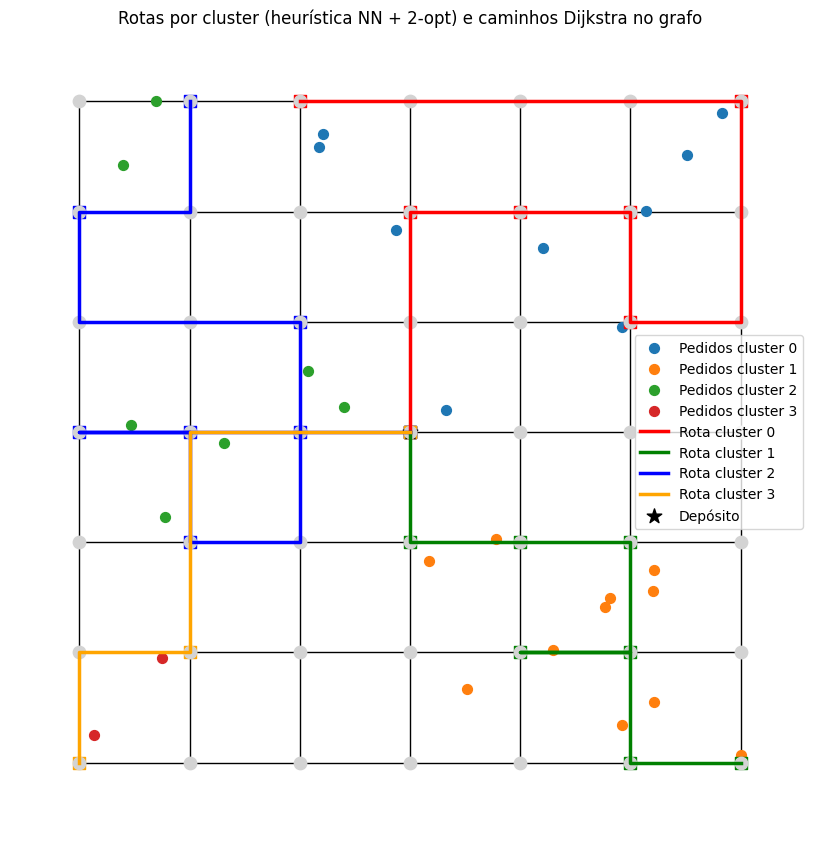

In [21]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Assume these variables are defined in previous cells
# If they are not, you might need to run those cells first
# or define them here based on your needs.
# For example, if the previous cells were not run:
# from the previous cells:
# rows, cols = 7, 7
# min_lat, max_lat = orders['lat'].min(), orders['lat'].max()
# min_lon, max_lon = orders['lon'].min(), orders['lon'].max()
# G, pos = build_grid_graph(rows, cols, min_lat, max_lat, min_lon, max_lon)
# depot_node = (rows//2, cols//2)
# routes_info = {} # You would need to populate this dictionary based on your route calculation logic


plt.figure(figsize=(8,8))
# desenha grafo base
nx.draw(G, pos=pos, node_color='lightgrey', node_size=80, with_labels=False)
# mostrar pedidos por cluster
for c in sorted(orders['cluster'].unique()):
    grp = orders[orders['cluster']==c]
    plt.scatter(grp['lon'], grp['lat'], s=50, label=f'Pedidos cluster {c}')
# cores para rotas
palette = ['red','green','blue','orange','purple','brown','cyan','magenta']
for c, info in routes_info.items():
    full_path = info['full_path']
    # desenha os nós do caminho
    path_coords = [pos[n] for n in full_path]
    xs = [p[0] for p in path_coords]; ys = [p[1] for p in path_coords]
    plt.plot(xs, ys, color=palette[c % len(palette)], linewidth=2.5, label=f'Rota cluster {c}')
    # marca nós do tour
    tour_nodes = info['tour_nodes']
    tour_coords = [pos[n] for n in tour_nodes]
    tx = [p[0] for p in tour_coords]; ty = [p[1] for p in tour_coords]
    plt.scatter(tx, ty, c=palette[c % len(palette)], s=80, marker='s')

# marca depósito
plt.scatter([pos[depot_node][0]], [pos[depot_node][1]], c='k', s=120, marker='*', label='Depósito')
plt.legend()
plt.title("Rotas por cluster (heurística NN + 2-opt) e caminhos Dijkstra no grafo")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.show()

## Conclusão

Com base no algoritmo **KMeans**, foi possível segmentar os pedidos em grupos distintos de acordo com a localização.  
Essa segmentação pode apoiar a empresa em:  
- **Otimização de rotas de entrega**,  
- **Melhoria do atendimento ao cliente**,  
- **Identificação de regiões de maior demanda**.  

A avaliação com o **Silhouette Score** confirmou que os clusters possuem qualidade satisfatória, validando a eficácia da técnica.  

Além disso, a **representação em grafo** permitiu mapear os pedidos em uma estrutura de rede, evidenciando como os pontos se conectam em uma malha geográfica.  
Essa abordagem é especialmente útil para problemas de **logística e roteirização**, pois facilita a análise de vizinhança e o cálculo de caminhos entre locais.  

Portanto, a combinação de **clustering (KMeans)** e **modelagem em grafo** oferece uma solução robusta para analisar e otimizar processos relacionados à logística da empresa.

